In [1]:
import numpy as np
import pandas as pd
from astropy.table import Table, vstack
from matplotlib import pyplot as plt
from glob import glob
from astropy.stats import LombScargle
from scipy import stats
import warnings
from TESStools import *
import celerite
from celerite import terms
from scipy.optimize import minimize

In [2]:
tid = 279957111

In [3]:
lc, lc_smooth = lc_extract(get_lc_from_id(tid), smooth=128)
time, flux, err = lc['Time'], lc['Flux'], lc['Err']

pseudo_NF = 0.5 / (np.mean(np.diff(time)))
ls = LombScargle(time, flux, normalization='psd')
freq, power = ls.autopower(minimum_frequency=1.0/30.0,
                    maximum_frequency=pseudo_NF) 

good_fs, good_amps, good_phases = prewhiten(time, flux, err)
harmonics = harmonic_search(good_fs)
combos = combo_search(good_fs)

f_Ny = 332.52345927965945, f_R = 0.036490914598590884
10
20
30
Found 33 frequencies
25 unique frequencies


In [4]:
harmonics

array([[0.11705849, 0.64113112],
       [0.9333847 , 3.19875548],
       [8.        , 5.        ]])

In [5]:
combos

array([[0.20327588, 0.20327588, 0.11705849, 0.27226816, 1.04145053,
        1.04145053, 1.24393495],
       [1.04145053, 1.1308004 , 1.48653861, 1.33240989, 2.30579937,
        2.15944146, 1.95391049],
       [1.24393495, 1.33240989, 1.60232584, 1.60232584, 3.3470861 ,
        3.19875548, 3.19875548]])

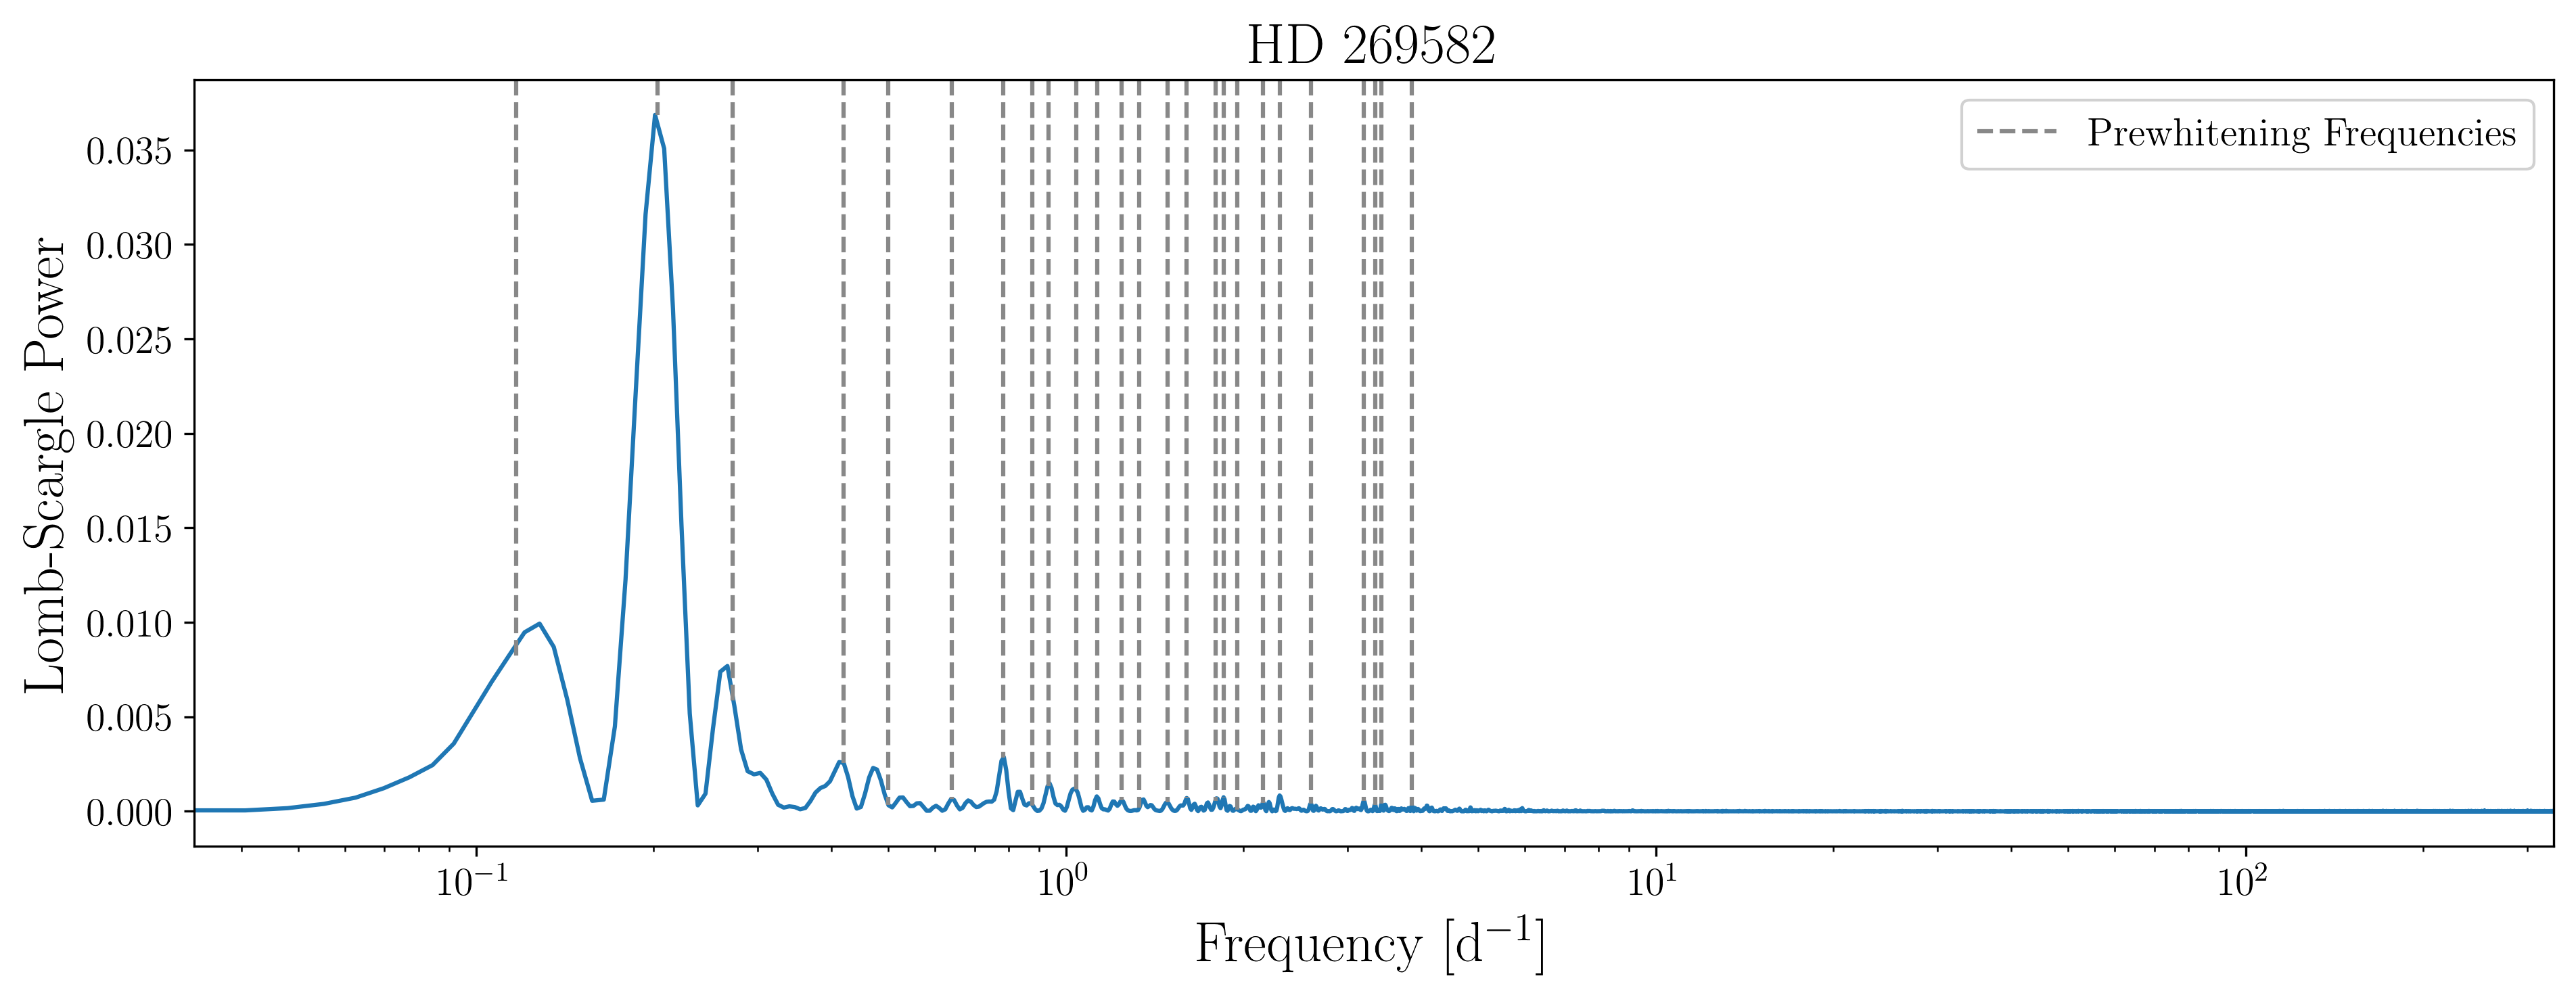

In [6]:
fig = plt.figure(figsize=(15,5),dpi=300)

plt.plot(freq, power)

ax = plt.gca()

ax.set(xlabel='Frequency [d$^{-1}$]', ylabel='Lomb-Scargle Power', xscale='log', xlim=(1/30,pseudo_NF))

ylim = ax.get_ylim()

plt.plot([good_fs[0,0],good_fs[0,0]],[ylim[1],power[np.argmin(np.abs(freq-good_fs[0,0]))]],c='#888888',ls='--',label='Prewhitening Frequencies')
for f in good_fs[1:,0]:
    plt.plot([f,f],[ylim[1],power[np.argmin(np.abs(freq-f))]],c='#888888',ls='--')
       
ax.set(ylim=ylim)
        
plt.legend(loc=1, framealpha=0.9, prop={'size': 14})

ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)

ax.set_title('HD 269582',fontsize=20)    
plt.savefig('../plots/HD269582_periodogram.pdf')

In [7]:
dom = 0.2032758787381713

/Users/carina/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


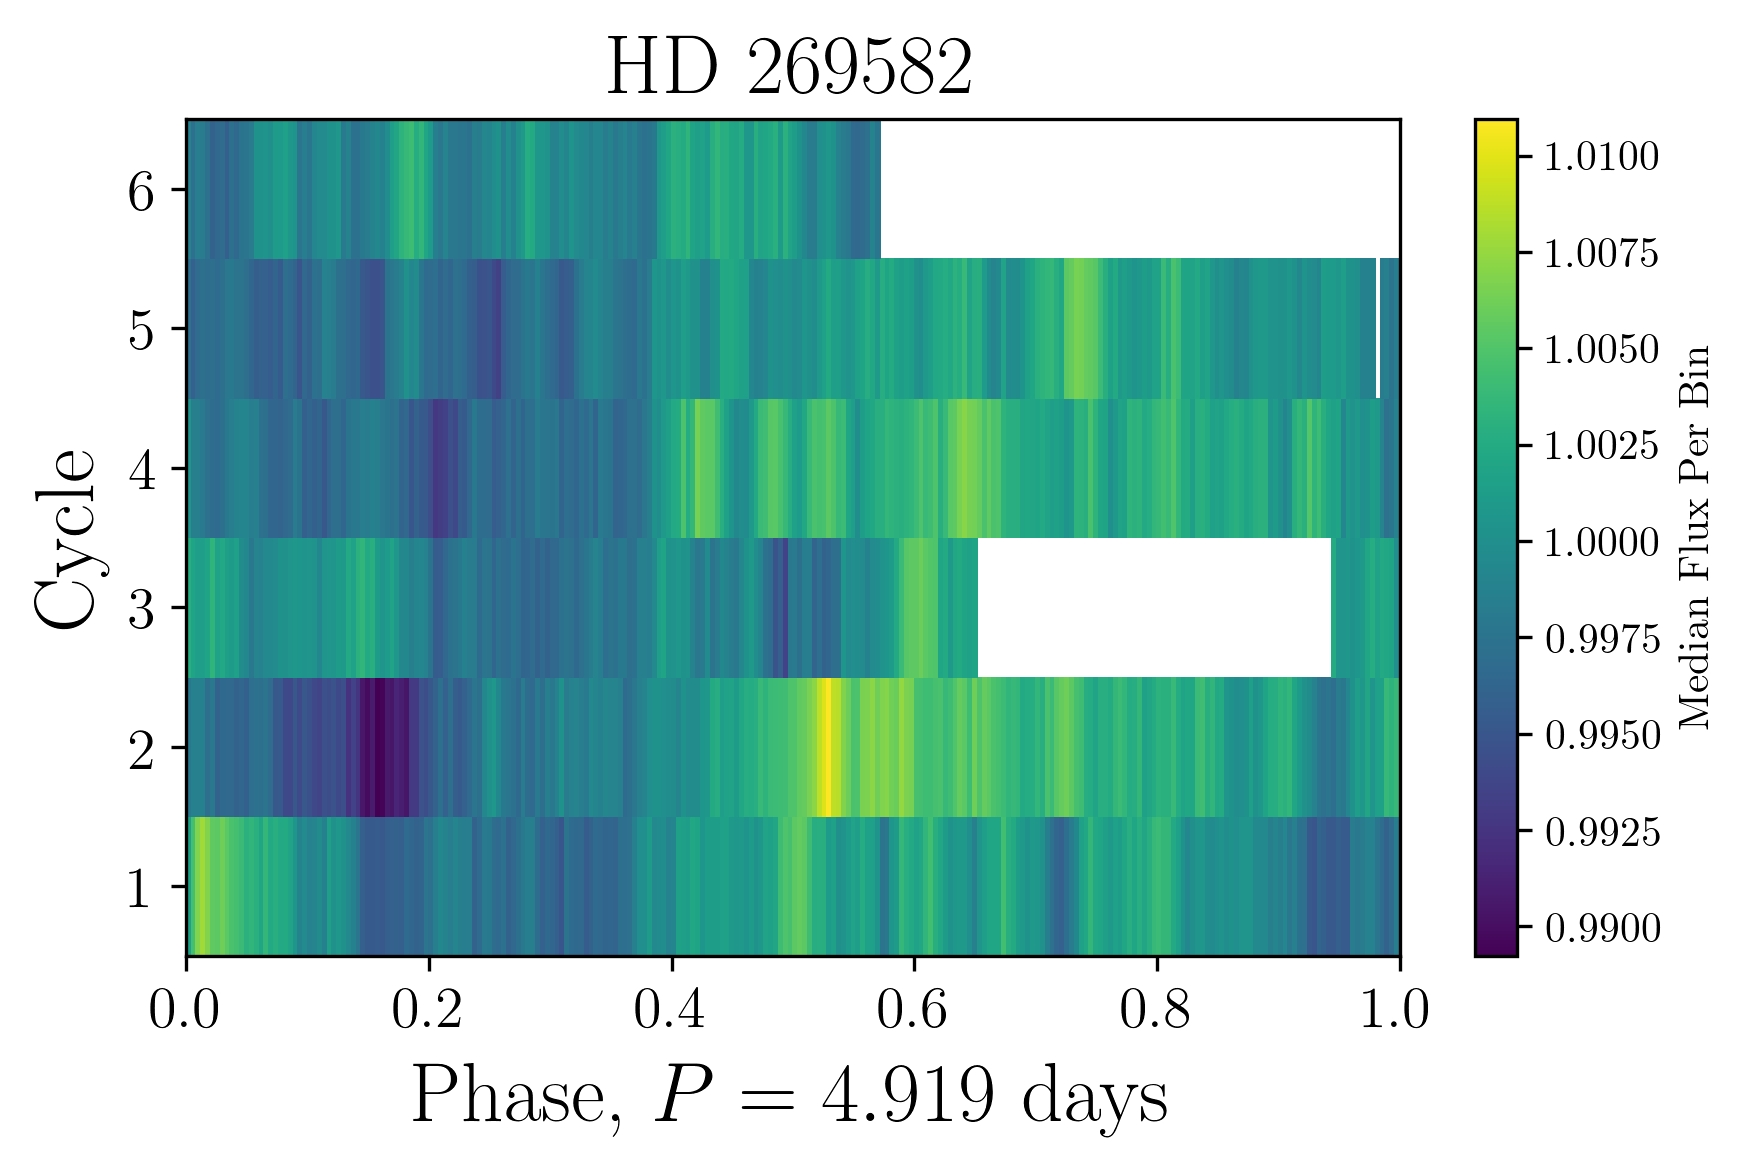

In [8]:
fig = plt.figure(dpi=300)
lc, lc_smooth = lc_extract(get_lc_from_id(tid), smooth=128)
time, flux = lc['Time'], lc['Flux']
cycle = np.floor((time-np.min(time))*dom)
phase = ((time-np.min(time))*dom) % 1
ybins = len(np.unique(cycle))
xbins = 250
H, xedges, yedges, binnumber = stats.binned_statistic_2d(phase, cycle, flux, statistic='median', bins=(xbins,ybins))  
H = np.ma.masked_where(H==0, H) #masking where there was no data
XX, YY = np.meshgrid(xedges, (ybins/(ybins-1))*yedges+0.5)
colobj = plt.pcolormesh(XX,YY,H.T)
plt.xlabel('Phase, $P = 4.919$ days')
plt.ylabel('Cycle')
ax = plt.gca()
plt.colorbar(colobj, ax=ax, label='Median Flux Per Bin')
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    

ax.set_title('HD 269582',fontsize=20)     
plt.tight_layout()   
plt.savefig('../plots/HD269582_dynamic.pdf')

Text(0.5, 1.0, 'HD 268687')

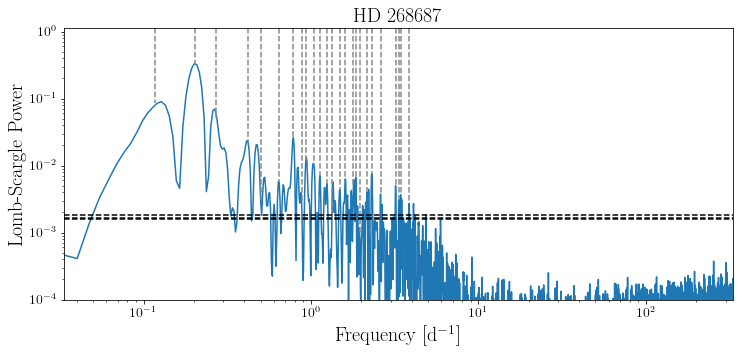

In [11]:
fig = plt.figure(figsize=(12,5))
lc, lc_smooth = lc_extract(get_lc_from_id(tid), smooth=128)
time, flux, err = lc['Time'], lc['Flux'], lc['Err']
ls = LombScargle(time, flux)
freq, power = ls.autopower() 
plt.loglog(freq, power)

ax = plt.gca()

ax.set(xlabel='Frequency [d$^{-1}$]',ylabel='Lomb-Scargle Power', xlim=(1/30,pseudo_NF))

ylim = ax.get_ylim()

plt.plot([good_fs[0,0],good_fs[0,0]],[ylim[1],power[np.argmin(np.abs(freq-good_fs[0,0]))]],c='#888888',ls='--',label='Prewhitening Frequencies')
for f in good_fs[1:,0]:
    plt.plot([f,f],[ylim[1],power[np.argmin(np.abs(freq-f))]],c='#888888',ls='--')
    
ax.set(ylim=(1e-4,ylim[1]))

probabilities = [0.1, 0.05, 0.01]
fal = ls.false_alarm_level(probabilities)
for f in fal:
    plt.axhline(y=f,c='k',ls='--')
        
#plt.legend(loc=1, framealpha=0.9, prop={'size': 14})

ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)

ax.set_title('HD 268687',fontsize=20)

In [17]:
good_fs[:,0][~np.array([power[np.argmin(np.abs(freq-f))] for f in good_fs[:,0]] >= fal[-1])]

array([1.95391049, 1.33240989])

/Users/carina/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


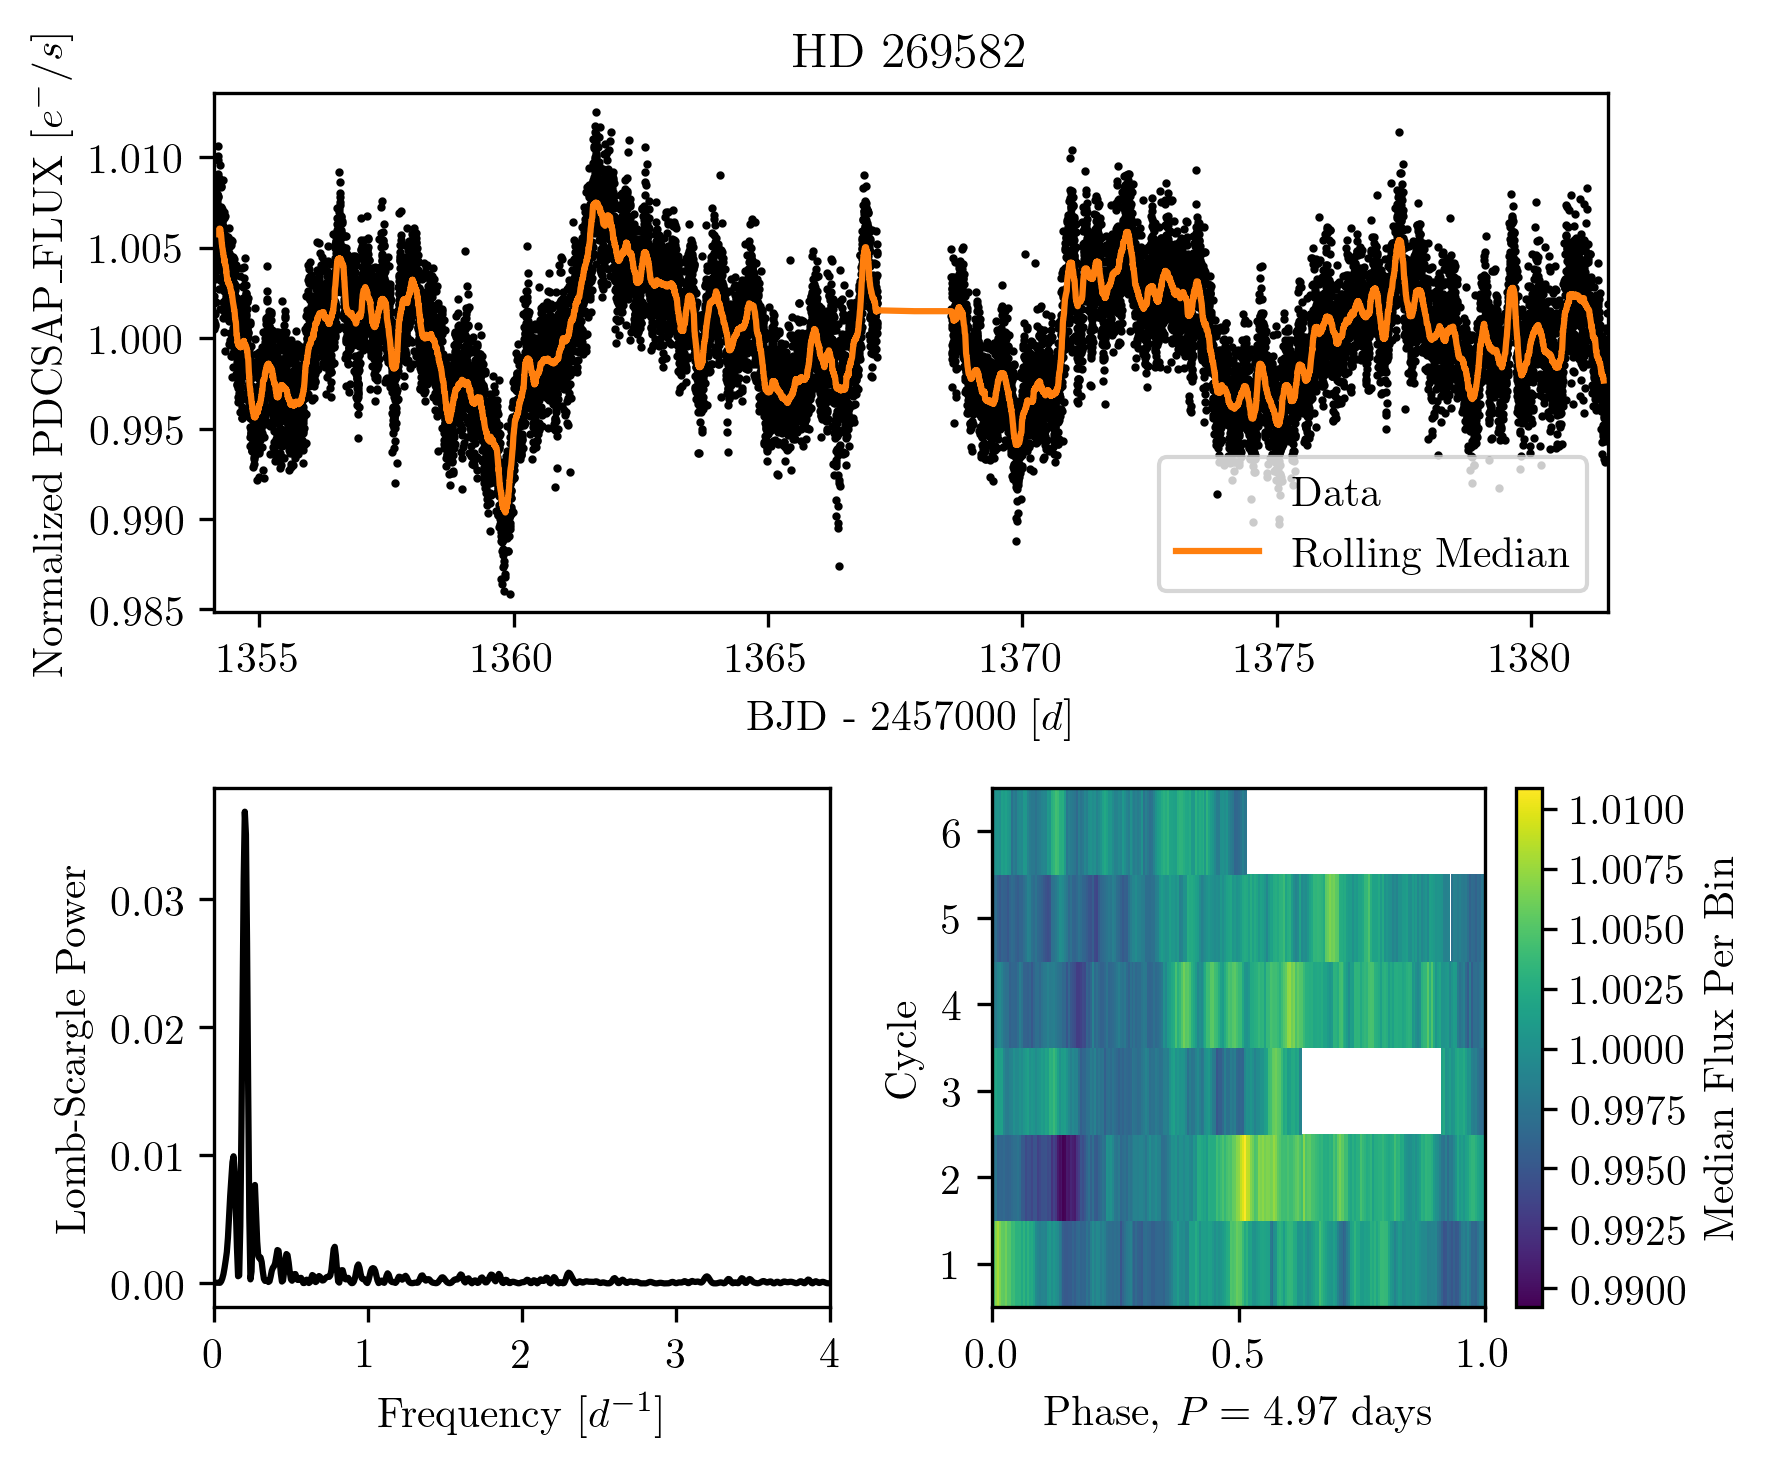

In [45]:
#Let's make a figure for the Cycle 2 proposal:
#Lightcurve
lc, lc_smooth = lc_extract(get_lc_from_id(tid), smooth=128)
#Lomb Scargle Object
ls = LombScargle(lc['Time'], lc['Flux'],normalization='psd')
pseudo_NF = 0.5 / (np.mean(np.diff(lc['Time'])))
f, p = ls.autopower(minimum_frequency=1.0/30.0,
                    maximum_frequency=pseudo_NF)

dom = f[np.argmax(p)]
dp = 1.0/dom

plt.figure(figsize=(6,5),dpi=300)
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
ax2 = plt.subplot2grid((2, 2), (1, 0))
ax3 = plt.subplot2grid((2, 2), (1, 1))

ax1.scatter(lc['Time'],lc['Flux'],s=1,label='Data',c='k')
ax1.plot(lc_smooth['Time'],lc_smooth['Flux'],c='C1',label='Rolling Median')
ax1.set(xlabel='BJD - 2457000 [$d$]', ylabel='Normalized PDCSAP\_FLUX [$e^-/s$]',
       xlim=(np.min(lc['Time']),np.max(lc['Time'])), 
       ylim=(0.999*np.min(lc['Flux']),1.001*np.max(lc['Flux'])),
       title='HD 269582')

h, l = ax1.get_legend_handles_labels()
ax1.legend(handles = h[::-1], labels = l[::-1])#, prop={'size': 14})

ax2.plot(f,p,c='k',lw=1.5)       
ax2.set(xlabel='Frequency [$d^{-1}$]', ylabel='Lomb-Scargle Power',xlim=(0,4))

cycle = np.floor((lc['Time']-np.min(lc['Time']))*dom)
phase = ((lc['Time']-np.min(lc['Time']))*dom) % 1
flux = lc['Flux']
ybins = len(np.unique(cycle))
xbins = 250
H, xedges, yedges, binnumber = stats.binned_statistic_2d(phase, cycle, flux, statistic='median', bins=(xbins,ybins))  
H = np.ma.masked_where(H==0, H) #masking where there was no data
XX, YY = np.meshgrid(xedges, (ybins/(ybins-1))*yedges+0.5)
colobj = ax3.pcolormesh(XX,YY,H.T)
ax3.set(xlabel='Phase, $P = 4.97$ days',ylabel='Cycle')
plt.colorbar(colobj, ax=ax3, label='Median Flux Per Bin')
plt.tight_layout()
plt.savefig('../../Proposals/TESS_C2/fig1a.pdf')

In [39]:
dom

0.2011915404868514

In [11]:
# Now let's do some of the GP stuff on this with twin SHOs
gp = dSHO_maxlikelihood(lc)

Initial log likelihood: 87954.42568551272
Final log likelihood: 89519.3043339297
Maximum Likelihood Soln: OrderedDict([('kernel:terms[0]:log_S0', -15.253047127104002), ('kernel:terms[0]:log_omega0', 2.8808568503497565), ('kernel:terms[1]:log_S0', -13.675418309267053), ('kernel:terms[1]:log_Q', 1.3815182716151988), ('kernel:terms[1]:log_omega0', 0.3357193196973752), ('kernel:terms[2]:log_sigma', -7.2964034434956115)])


In [12]:
omega_0 = np.exp(0.33571)
dom_gp = 2.0*np.pi/omega_0
dom_gp

4.491411719187451

/Users/carina/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


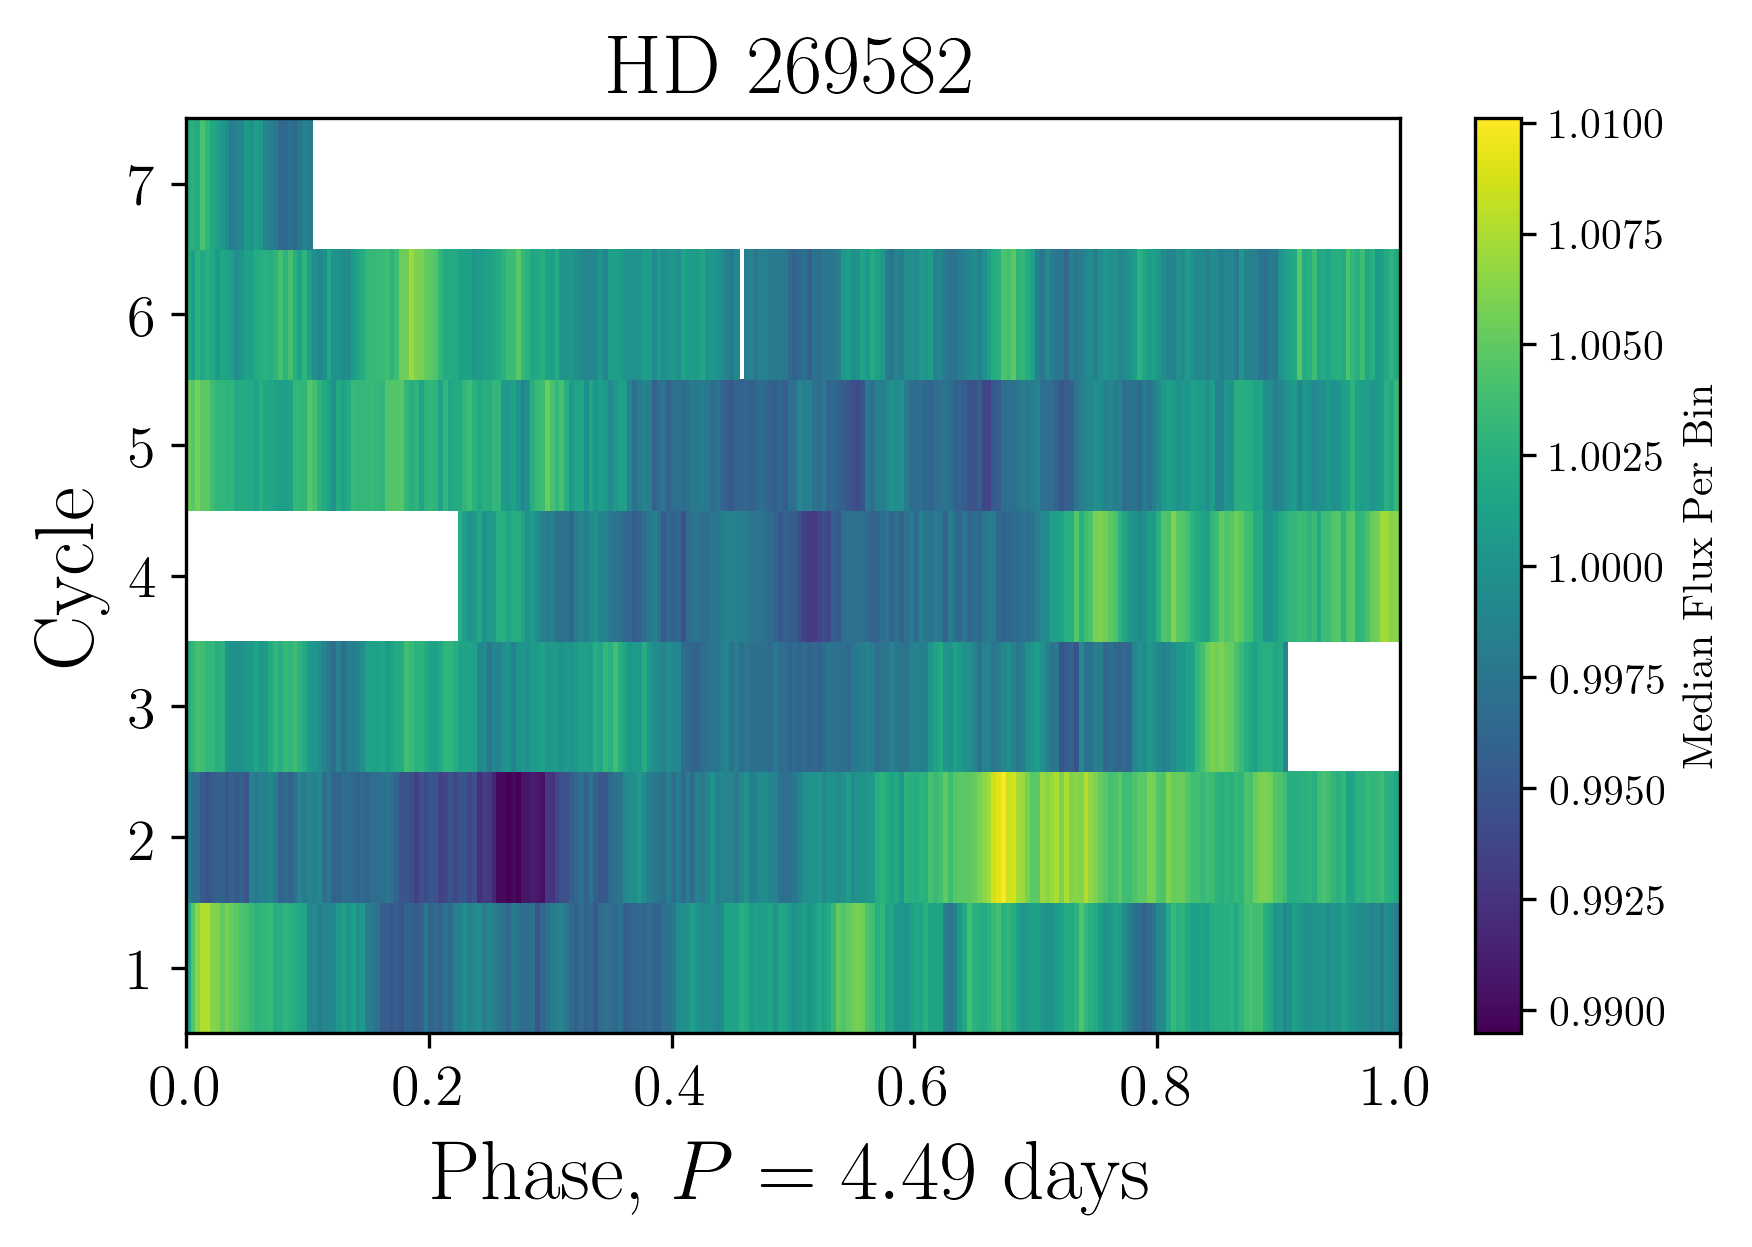

In [15]:
fig = plt.figure(dpi=300)
cycle = np.floor((lc['Time']-np.min(lc['Time']))/dom_gp)
phase = ((lc['Time']-np.min(lc['Time']))/dom_gp) % 1
flux = lc['NormFlux']
ybins = len(np.unique(cycle))
xbins = 250
H, xedges, yedges, binnumber = stats.binned_statistic_2d(phase, cycle, flux, statistic='median', bins=(xbins,ybins))  
H = np.ma.masked_where(H==0, H) #masking where there was no data
XX, YY = np.meshgrid(xedges, (ybins/(ybins-1))*yedges+0.5)
colobj = plt.pcolormesh(XX,YY,H.T)
plt.xlabel('Phase, $P = 4.49$ days')
plt.ylabel('Cycle')
ax = plt.gca()
plt.colorbar(colobj, ax=ax, label='Median Flux Per Bin')
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    
plt.tight_layout()
ax.set_title('HD 269582',fontsize=20)    
plt.savefig('../plots/HD269582_dynamicgp.pdf')

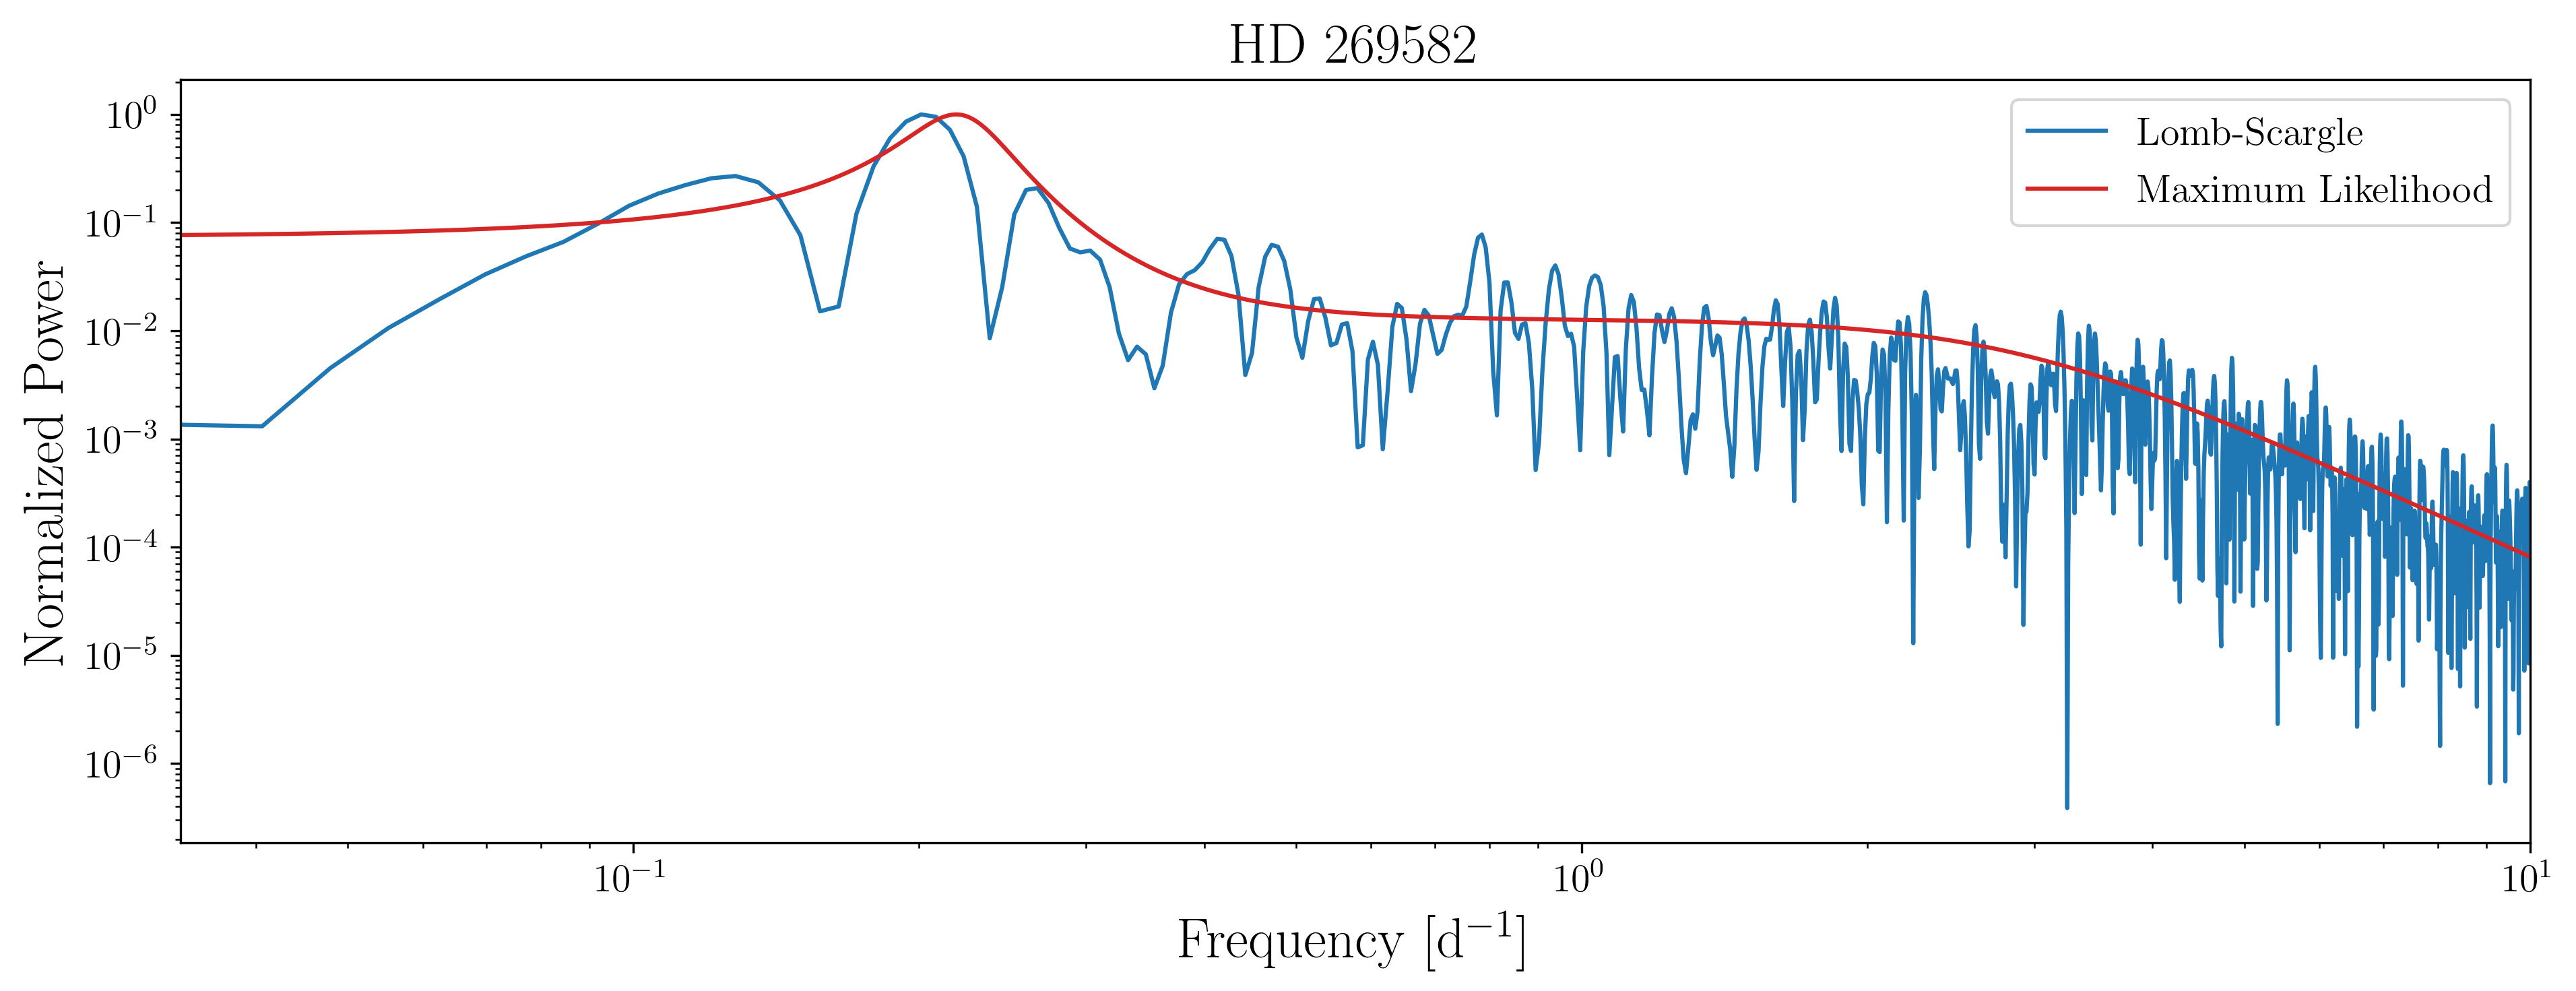

In [16]:
fig = plt.figure(figsize=(15,5),dpi=300)

omega = np.exp(np.linspace(np.log(2.0*np.pi/30.0), np.log(2.0*np.pi/0.1), 5000))
plt.loglog(f,p/np.max(p),c='C0',label='Lomb-Scargle')

psd = gp.kernel.get_psd(omega)
plt.loglog(omega/(2.0*np.pi), psd/np.max(psd), color='C3', label='Maximum Likelihood')

plt.xlabel("Frequency [d$^{-1}$]")
plt.ylabel("Normalized Power")
plt.xlim(1/30,1/0.1)
plt.legend(fontsize=14)
ax = plt.gca()
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
ax.set_title('HD 269582',fontsize=20) 
plt.savefig('../plots/HD269582_power.pdf')

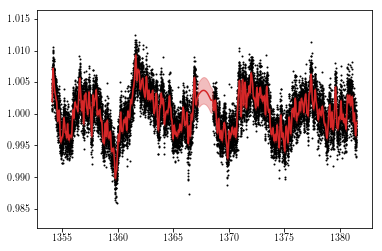

In [12]:
x = np.linspace(np.min(lc['Time']), np.max(lc['Time']), 5000)
pred_mean, pred_var = gp.predict(lc['NormFlux'], x, return_var=True)
pred_std = np.sqrt(pred_var)

plt.scatter(lc['Time'], lc['NormFlux'], s=1, c='k')
plt.plot(x, pred_mean, color='C3')
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color='C3', alpha=0.3,
                 edgecolor="none")

In [21]:
sampler, gp = dSHO_emcee(lc, gp)

Running 500 steps of burn-in...
Running 3000 steps of production...


(0.03333333333333333, 10.0)

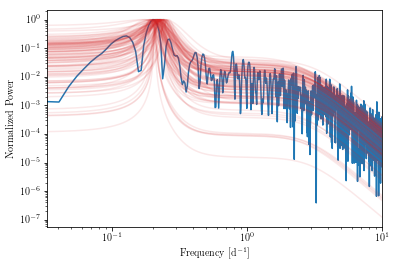

In [22]:
omega = np.exp(np.linspace(np.log(2.0*np.pi/30.0), np.log(2.0*np.pi/0.1), 5000))
plt.plot(f,p/np.max(p),c='C0')

samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=100)]:
    gp.set_parameter_vector(s)
    psd = gp.kernel.get_psd(omega)
    plt.plot(omega/(2.0*np.pi), psd/np.max(psd), alpha=0.1, color='C3')

plt.yscale("log")
plt.xscale("log")
plt.xlabel("Frequency [d$^{-1}$]")
plt.ylabel("Normalized Power")
plt.xlim(1/30,1/0.1)